# Redes de Convolução

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/Users/marcocristo/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import tensorflow as tf

/Users/marcocristo/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# reinicia grafo do tensorflow
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# Convoluções

In [4]:
import skimage.measure # scikit-image

Para entendermos convolução e pooling, vamos inicialmente ver o que essas operações fazem em pequenos exemplos de imagens.

Para isso, vamos criar uma função para exibir matrizes como imagens em tons de cinza.

In [5]:
def plot_figs(lst):
    if len(lst) == 1:
        plt.matshow(lst[0], cmap = 'gray', interpolation='nearest')
    else:
        f, axes = plt.subplots(1, len(lst))
        for i, a in enumerate(axes):
            a.matshow(lst[i], cmap = 'gray', interpolation='nearest')
            a.set(aspect='equal')

E então exibir exemplos de imagens simples (ex0 e ex1) e de um kernel simples (k0):

In [6]:
ex0 = np.array([[0,0,0,1,0,0,0,0],
                [0,0,1,0,0,0,0,0],
                [0,1,0,0,0,0,0,0],
                [1,0,0,0,0,0,0,0],
                [0,0,0,0,1,0,0,0],
                [0,0,0,0,0,1,0,0],
                [0,0,0,0,0,0,1,0],
                [0,0,0,0,0,0,0,1]], dtype=np.float32)

In [7]:
ex1 = np.array([[0,0,0,0,0,0,0,1],
                [0,0,0,0,0,0,0,1],
                [0,0,0,0,0,0,1,0],
                [0,0,0,0,0,0,1,0],
                [0,0,0,0,0,1,0,0],
                [0,0,0,0,0,1,0,0],
                [0,0,0,0,1,0,0,0],
                [0,0,0,0,1,0,0,0]], dtype=np.float32)

In [8]:
k0 = np.array([[0,0,0,1],
               [0,0,1,1],
               [0,0,1,0],
               [0,1,0,0]], dtype=np.float32)

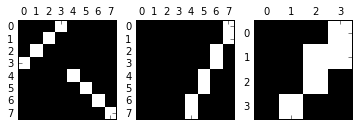

In [9]:
plot_figs([ex0, ex1, k0])

O componente básico da operação de convolução é o produto (interno) entre a entrada ($\bf{x}$) e o kernel ($\bf{w}$), com saída opcionalmente transformada, por exemplo, para ter uma interpretação probabilística. Ou seja, ela pode ser representada como $\sigma({\bf x}^{T} {\bf w})$, onde $\sigma$ pode ser a função sigmoid:

In [10]:
def conv0(a1, a2):
    sigmoid = lambda n: 1. / (1. + np.exp(-n))
    a1r = a1.reshape((-1, 1))
    a2r = a2.reshape((-1, 1))
    return sigmoid(np.sum(np.multiply(a1r, a2r)))
    # return sigmoid(np.dot(a1r.T, a2r))[0,0]

0.880797079331918

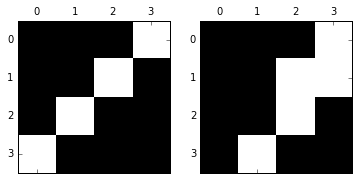

In [11]:
plot_figs([ex0[:4,:4], k0])
conv0(ex0[:4,:4], k0)

Ao aplicar conv0 para k0 e a parte superior esquerda de ex0, notamos que o padrão k0 é parcialmente observado em ex0 (probabilidade de 88%).

0.731058573739949

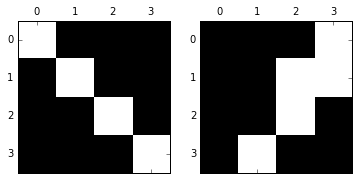

In [12]:
plot_figs([ex0[4:,4:], k0])
conv0(ex0[4:,4:], k0)

Ao aplicar conv0 para k0 e a parte inferior direira de ex0, notamos que o padrão k0 é observado com certeza menor (probabilidade de 73%), umas vez que houve coincidência em um único ponto.

0.9525741281753408

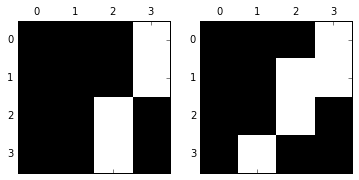

In [13]:
ex1p = skimage.measure.block_reduce(ex1, (2,2), np.max)
plot_figs([ex1p, k0])
conv0(ex1p, k0)

Ao aplicar conv0 para k0 e uma versão _reduzida_ de ex1, notamos que o padrão k0 é observado com certo grau de certeza (probabilidade de 95%).

Destes exemplos, podemos interpretar a operação de convolução como um problema de dizer se um padrão pode ou não ser visto em uma imagem. Podemos ver também que reduzir a imagem (uma operação de _pooling_) pode tornar um padrão visível.

A seguir, vamos ver a aplicação da operação de convolução completa de um kernel sobre uma imagem.

Para isso vamos usar o operador de convolução conv2D do tensorflow. Os parâmetros deste operador são a imagem de entrada (tensor 4D [número de batches, altura, largura, número de canais]), o conjunto de kernels a serem aplicados (tensor 4D [altura, largura, canais de entrada, canais de saída]), os delocamentos a serem aplicados (no conjunto de batches, nos pixels da altura, pixels da largura e canais de entrada) e o tipo de _padding_ a ser realizado ('VALID' = sem padding ou 'SAME' = tentar manter o mesmo padding em cada margem). 

In [14]:
def tfconv(imgs, kernels):
    reset_graph()

    # batch, alt, larg, canais entrada
    X = tf.constant(imgs, dtype=tf.float32) 
    feature_maps = tf.constant(kernels)
    convolution = tf.nn.conv2d(X, feature_maps, strides=[1,1,1,1], 
                               padding="SAME")
    
    with tf.Session() as s:
        output = convolution.eval(feed_dict={X: imgs})
    return output

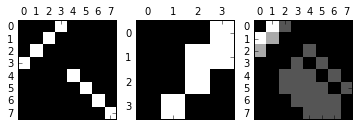

In [15]:
# alt, larg, canais de entrada, canais de saida
fmap = k0.reshape(k0.shape[0], k0.shape[1], 1, 1)
output = tfconv(ex0.reshape(1, ex0.shape[0], ex0.shape[1], 1), fmap)
plot_figs([ex0, k0, output[0, :, :, 0]])

Ao aplicar convolução do kernel k0 em ex0, notamos que o padrão k0 é observado na parte superior esquerda da imagem, mas não muito claramente na parte inferior esquerda. Esta é a forma como pode ser interpretada a imagem resultante da convolução.

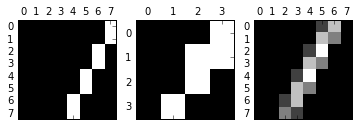

In [16]:
output = tfconv(ex1.reshape(1, ex1.shape[0], ex1.shape[1], 1), fmap)
plot_figs([ex1, k0, output[0, :, :, 0]])

Ao aplicar convolução do kernel k0 em ex1, notamos que o padrão k0 parece ser observado ao longo de ex1, ao lado esquerdo (em particular, mais na parte superior que na parte inferior da imagem).

Finalmente, vamos ver o efeito de padrões (kernels) mais complexos em uma imagem real.

In [17]:
im = Image.open('images/building.jpeg') 
image = np.asarray(im) 

IOError: [Errno 2] No such file or directory: 'images/building.jpeg'

In [18]:
plt.imshow(image)

NameError: name 'image' is not defined

In [19]:
image.shape

(183, 275, 3)

In [20]:
height, width, channels = image.shape
image_grayscale = image.mean(axis=2).astype(np.float32)
images = image_grayscale.reshape(1, height, width, 1)

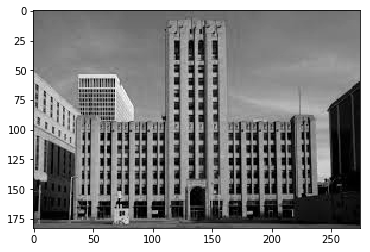

In [21]:
plt.imshow(images[0,:,:,0], cmap = 'gray')

Para tanto, vamos usar dois padrões: uma linha verticar e outra horizontal.

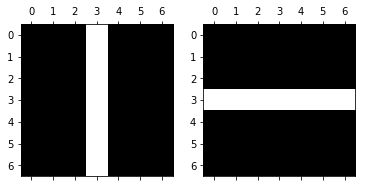

In [22]:
fmap = np.zeros(shape=(7, 7, 1, 2), dtype=np.float32)
fmap[:, 3, 0, 0] = 1
fmap[3, :, 0, 1] = 1
plot_figs([fmap[:, :, 0, 0], fmap[:, :, 0, 1]])

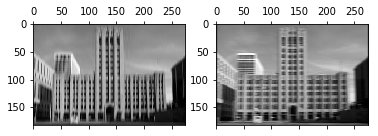

In [23]:
output = tfconv(images, fmap)
plot_figs([output[0, :, :, 0], output[0, :, :, 1]])

Percebam que, na imagem resultante, são ressaltadas as linhas verticais e horizontais da imagem original, enfatizando _onde_ esses padrões são vistos.

A seguir, vamos parametrizar nossa função de convolução para observar o efeito de diferentes strides e padding.

In [123]:
def tfconv(img, kernels, stride_val = 1, pad_val = 'SAME'):
    reset_graph()

    # batch, alt, larg, canais entrada
    X = tf.constant(img, dtype=tf.float32) 
    feature_maps = tf.constant(kernels)
    convolution = tf.nn.conv2d(X, feature_maps, 
                               strides=[1, stride_val, stride_val, 1], 
                               padding=pad_val)
    
    with tf.Session() as s:
        output = convolution.eval(feed_dict={X: img})
    return output

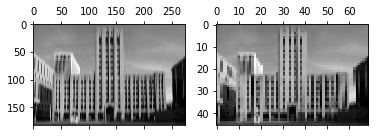

In [25]:
# stride 4 --> imagem é reduzida 4 vezes
output4 = tfconv(images, fmap, 4)
plot_figs([output[0, :, :, 0], output4[0, :, :, 0]])

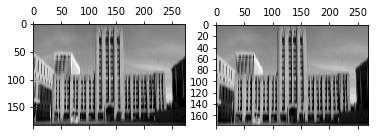

In [26]:
# sem padding, quase não se nota mudança em uma imagem tão grande, exceto nas bordas.
outputv = tfconv(images, fmap, pad_val = 'VALID')
plot_figs([output[0, :, :, 0], outputv[0, :, :, 0]])

Vamos agora introduzir pooling no processo. Note que o efeito do pooling é similar a striding na convolução, ou seja, redução da imagem.

In [121]:
def tfconv_p(img, kernels, stride_val = 1, pad_val = 'SAME', pool_val = 2):
    reset_graph()

    # batch, alt, larg, canais entrada
    X = tf.constant(img, dtype=tf.float32) 
    feature_maps = tf.constant(kernels)
    convolution = tf.nn.conv2d(X, feature_maps, 
                               strides=[1, stride_val, stride_val, 1], 
                               padding=pad_val)
    # max pool!!!
    max_pool = tf.nn.max_pool(convolution, 
                              ksize=[1, pool_val, pool_val, 1], 
                              strides=[1,pool_val,pool_val,1], 
                              padding="VALID")
    
    with tf.Session() as s:
        output = max_pool.eval(feed_dict={X: img})
    return output

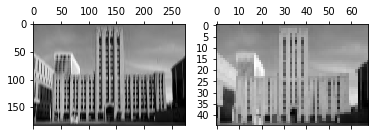

In [122]:
outputmax = tfconv_p(images, fmap, pool_val = 4)
plot_figs([output[0, :, :, 0], outputmax[0, :, :, 0]])

## Uma rede de convolução (CNN - Convolutional Neural Network)

Uma rede de convolução é basicamente uma rede neural com camadas em que se aplicam convoluções e pooling. Os pesos dos neurônios em camadas de convolução correspondem a kernels. Logo, os neurônios filtram as imagens que chegam em busca de padrões partculares. Os pesos nas camadas de pooling são sempre 1 e nunca se alteram. Ou seja, elas não fazem nada além de algum tipo de amostragem, reduzindo a quantidade de informação que vai seguir pela rede.

Abaixo, vamos usar uma CNN para classificar MNIST.

Nossa CNN tem $28 \times 28$ sinais de entrada. Estes sinais são entregues para um rede de convolução com 8 kernels. As 8 imagens resultantes de $28 \times 28$ pixels sao entrada de uma segunda rede de convolução, com 16 kernels e stride 2. Ou seja, ela reduz a entrada produzindo 16 imagens de $14 \times 14$ pixels. Esses passam por uma camada de pooling que os reduz para 16 imagens de $7 \times 7$ pixels. 

In [32]:
from keras import layers
from keras import models
import keras.backend as K

In [33]:
K.clear_session()

In [34]:
model = models.Sequential()

model.add(layers.Conv2D(8, (3, 3), activation = 'relu', input_shape = (28, 28, 1)))
model.add(layers.Conv2D(16, (3, 3), strides = (2, 2), padding = 'same', activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2), padding = 'same'))

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 8)         80        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
Total params: 1,248
Trainable params: 1,248
Non-trainable params: 0
_________________________________________________________________


Esses $16 \times 7 \times 7$ sinais são então dados como entrada para 64 neurônios (camada que chamamos FC1) que, por sua vez, se conectam com outros 10 neurônios. Cada neurônio deste, então, representa um digito diferente. Logo eles podem ser combinados via _softmax_ para determinar o dígito mais provável da rede.

In [36]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation = 'relu', name = 'FC1'))
model.add(layers.Dense(10, activation = 'softmax', name = 'output'))

In [37]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 8)         80        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
FC1 (Dense)                  (None, 64)                50240     
_________________________________________________________________
output (Dense)               (None, 10)                650       
Total params: 52,138
Trainable params: 52,138
Non-trainable params: 0
_________________________________________________________________


In [38]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/MNIST_data")

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [39]:
train_images = mnist.train.images.reshape((55000, 28, 28, 1))
test_images = mnist.test.images.reshape((10000, 28, 28, 1))

In [40]:
from keras.utils import to_categorical

In [41]:
train_labels = to_categorical(mnist.train.labels)
test_labels = to_categorical(mnist.test.labels)

In [42]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [43]:
model.fit(train_images, train_labels, epochs = 5, batch_size = 64)

Epoch 1/5
55000/55000 [==============================] - 6s - loss: 0.3058 - acc: 0.9095     
Epoch 2/5
55000/55000 [==============================] - 5s - loss: 0.1047 - acc: 0.9681     
Epoch 3/5
55000/55000 [==============================] - 6s - loss: 0.0732 - acc: 0.9771     
Epoch 4/5
55000/55000 [==============================] - 6s - loss: 0.0557 - acc: 0.9821     
Epoch 5/5
55000/55000 [==============================] - 5s - loss: 0.0442 - acc: 0.9857     


In [44]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
test_acc

 9504/10000 [===========================>..] - ETA: 0s

0.9845

E a nossa primeira e simples CNN já atingiu uma alta taxa de classificação, da ordem de 98.5%. 

Como seria o equivalente em tensorflow?

```python
#
# modelo
#

height = 28
width = 28
channels = 1
n_inputs = height * width

reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
    X_reshaped = tf.reshape(X, shape=(-1, height, width, channels))
    y = tf.placeholder(tf.int32, shape=(None), name="y")

# input: 28x28 image (batch images)
conv1 = tf.layers.conv2d(X_reshaped, filters=8, kernel_size=3,
                         strides=1, padding='SAME',
                         activation=tf.nn.relu, name="conv1")
# input: 8 28x28
conv2 = tf.layers.conv2d(conv1, filters=16, kernel_size=3,
                         strides=2, padding='SAME',
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    # input: 16 14x14 
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], 
                           strides=[1, 2, 2, 1], padding="VALID")
    # output: 16 7x7 
    pool3_flat = tf.reshape(pool3, shape=(-1, 16 * 7 * 7))

with tf.name_scope("fc1"):
    # input: 16x7x7
    fc1 = tf.layers.dense(pool3_flat, 64, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, 10, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
#
# treino & avaliacao
#
n_epochs = 5
batch_size = 64

with tf.Session() as s:
    init.run()
    for e in range(n_epochs):
        for i in range(mnist.train.num_examples // batch_size):
            X_b, y_b = mnist.train.next_batch(batch_size)
            s.run(training_op, feed_dict={X: X_b, y: y_b})
        acc_tr = accuracy.eval(feed_dict={X: X_b, y: y_b})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images, 
                                            y: mnist.test.labels})
        print '%d: acc tr = %.5f test = %.5f' % (e, acc_tr, acc_test)

        saver.save(s, "/tmp/my_mnist_model")
```

A seguir, vamos tentar melhorar nossa arquitetura introduzindo droput nas camadas de pooling e FC1, além de permitir que ela treine por mais épocas (o treino será finalizado usando _early stopping_).

In [48]:
K.clear_session()

In [49]:
# com dropout 
model = models.Sequential()

model.add(layers.Conv2D(8, (3, 3), activation = 'relu', input_shape = (28, 28, 1)))
model.add(layers.Conv2D(16, (3, 3), strides = (2, 2), padding = 'same', activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2), padding = 'same'))

model.add(layers.Flatten())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(64, activation = 'relu', name = 'FC1'))
model.add(layers.Dropout(0.50))
model.add(layers.Dense(10, activation = 'softmax', name = 'output'))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [50]:
model.fit(train_images, train_labels, epochs = 5, batch_size = 64)

Epoch 1/5
55000/55000 [==============================] - 6s - loss: 0.5436 - acc: 0.8274     
Epoch 2/5
55000/55000 [==============================] - 6s - loss: 0.2432 - acc: 0.9270     
Epoch 3/5
55000/55000 [==============================] - 6s - loss: 0.1872 - acc: 0.9447     
Epoch 4/5
55000/55000 [==============================] - 6s - loss: 0.1613 - acc: 0.9508     
Epoch 5/5
55000/55000 [==============================] - 6s - loss: 0.1438 - acc: 0.9562     


In [51]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
test_acc

 9376/10000 [===========================>..] - ETA: 0s

0.9843

Para implementar _early stopping_, vamos usar um _callback_ do Keras. 

In [52]:
from keras.callbacks import EarlyStopping

In [53]:
K.clear_session()

In [61]:
# com dropout 
model = models.Sequential()

model.add(layers.Conv2D(8, (3, 3), activation = 'relu', input_shape = (28, 28, 1)))
model.add(layers.Conv2D(16, (3, 3), strides = (2, 2), padding = 'same', activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2), padding = 'same'))

model.add(layers.Flatten())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(64, activation = 'relu', name = 'FC1'))
model.add(layers.Dropout(0.50))
model.add(layers.Dense(10, activation = 'softmax', name = 'output'))

earlystopping = EarlyStopping(monitor='val_loss', patience = 2, min_delta = 0, verbose=0)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [65]:
model.fit(train_images, train_labels, epochs = 20, validation_split = 0.05,
          batch_size = 64, callbacks = [earlystopping])

Train on 52250 samples, validate on 2750 samples
Epoch 1/20
52250/52250 [==============================] - 6s - loss: 0.0987 - acc: 0.9687 - val_loss: 0.0430 - val_acc: 0.9902
Epoch 2/20
52250/52250 [==============================] - 6s - loss: 0.0934 - acc: 0.9704 - val_loss: 0.0430 - val_acc: 0.9891
Epoch 3/20
52250/52250 [==============================] - 6s - loss: 0.0932 - acc: 0.9707 - val_loss: 0.0375 - val_acc: 0.9909
Epoch 4/20
52250/52250 [==============================] - 6s - loss: 0.0958 - acc: 0.9703 - val_loss: 0.0406 - val_acc: 0.9895
Epoch 5/20
52250/52250 [==============================] - 6s - loss: 0.0923 - acc: 0.9719 - val_loss: 0.0396 - val_acc: 0.9902
Epoch 6/20
52250/52250 [==============================] - 6s - loss: 0.0888 - acc: 0.9714 - val_loss: 0.0416 - val_acc: 0.9895


In [66]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
test_acc

 9824/10000 [============================>.] - ETA: 0s

0.988

Esta rede, mesmo usando poucos kernels já é capaz de alcançar taxas de acerto superiores a 99%.

Como isso poderia ser feito em tensorflow?

```python
# save and restore net in memory
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)
    
# treino com early stopping
n_epochs = 1000
batch_size = 50

best_loss_val = np.infty
check_interval = 500
no_progress = 0
max_no_progress = 20
best_model_params = None 

with tf.Session() as s:
    init.run()
    for e in range(n_epochs):
        for i in range(mnist.train.num_examples // batch_size):
            X_b, y_b = mnist.train.next_batch(batch_size)
            s.run(training_op, feed_dict={X: X_b, y: y_b, training: True}) # dropout
            if i % check_interval == 0:
                loss_val = loss.eval(feed_dict={X: mnist.validation.images,
                                                y: mnist.validation.labels})
                if loss_val < best_loss_val:
                    best_loss_val = loss_val
                    no_progress = 0
                    best_model_params = get_model_params()
                else:
                    no_progress += 1
        acc_train = accuracy.eval(feed_dict={X: X_b, y: y_b})
        acc_val = accuracy.eval(feed_dict={X: mnist.validation.images,
                                           y: mnist.validation.labels})
        print("%2d: train acc: %.5f, val acc: %.5f, curr best loss: %.5f" % (
                  e, acc_train, acc_val, best_loss_val))
        if no_progress > max_no_progress:
            print("Early stopping!")
            break

    if best_model_params:
        restore_model_params(best_model_params)
    acc_test = accuracy.eval(feed_dict={X: mnist.test.images,
                                        y: mnist.test.labels})
    print "acc test:", acc_test
    saver.save(s, "/tmp/my_mnist_model")
```

### Observando pesos de camadas

Uma forma de compreender melhor redes neurais é observando os pesos que foram aprendidos. No caso de processamento de imagens, onde os pesos representam os padrões visuais que os neurônios reconhecem, eles podem ser facilmente interpretáveis.

Abaixo listamos os parâmetros observados no melhor modelo aprendido anteriormente.

In [90]:
weights = model.get_weights()

In [87]:
wnames = []
for l in model.layers:
    for ws in l.weights:
        wnames += [ws.name]
wnames

[u'conv2d_9/kernel:0',
 u'conv2d_9/bias:0',
 u'conv2d_10/kernel:0',
 u'conv2d_10/bias:0',
 u'FC1_4/kernel:0',
 u'FC1_4/bias:0',
 u'output_4/kernel:0',
 u'output_4/bias:0']

In [94]:
dweights = dict(zip(wnames, weights))

In [95]:
dweights['conv2d_9/kernel:0'].shape

(3, 3, 1, 8)

In [96]:
dweights['conv2d_9/kernel:0'][:,:,0,0].reshape(3,3)

array([[ 0.3559067 ,  0.46280023,  0.60635394],
       [-0.49744603, -0.1837974 ,  0.5339547 ],
       [-0.6149816 , -0.4161143 ,  0.09261917]], dtype=float32)

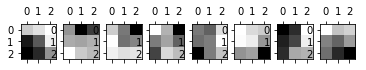

In [98]:
plot_figs([dweights['conv2d_9/kernel:0'][:,:,0,i] for i in range(8)])

Note que como nesta rede usamos kernels de tamanho 3x3, não há padrões muito significativos a observar. Este não é o caso de redes onde são usados kernels maiores, em que padrões muito característicos são observados. Por exemplo, abaixo, podemos ver kernels de diferentes camadas na rede AlexNet (imagem de http://vision03.csail.mit.edu/cnn_art/index.html):

![](images/alexnet_weights.png)

Claramente, camadas mais profundas apresentam padrões mais complexos. Assim, vemos bordas e manchas coloridas na primeira camada, texturas na terceira, partes de objetos na quinta e padrões complexos na oitava.

### Rede Neural como codificador distribuído

Outra característica interessante de redes neurais é que a saída dela para uma instância em qualquer camada, pode ser tomada como uma representação _comprimida_ e _distribuída_ daquela instância (um _embedding_). Como tais representações são baseadas nos mesmos conjuntos de características, espera-se que elas sejam similares para instâncias que compartilham as mesmas características. Logo, duas instâncias do número 0 devem ter representação similar, porém diferente do número 1, por exemplo. 

Para observarmos isso, vamos tomar a representação correspondente à camada totalmente conectada da nossa rede, a fc1:

In [99]:
dweights['FC1_4/kernel:0'].shape

(784, 64)

In [101]:
from keras.models import Model

In [106]:
model_at_layer = Model(inputs=model.input, 
                       outputs=model.get_layer('FC1').output)
Xs = mnist.test.images[:100].reshape(100,28,28,1)
fc1_vals = model_at_layer.predict(Xs)

Note que fc1_vals tem as saídas dos neurônios da camada fc1 para as 100 primeiras imagens da coleção de teste.

In [107]:
from sklearn.neighbors import NearestNeighbors
import random

In [108]:
neigh = NearestNeighbors(2)
neigh.fit(fc1_vals) 

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=2, p=2, radius=1.0)

Se tomarmos aleatoriamente uma imagem em fc1_vals e seus 4 vizinhos mais próximos, de acordo com a representação feita pelos neurônios, observe o que obtemos:

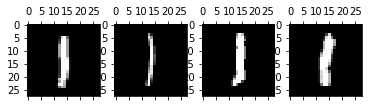

In [111]:
rquery = random.randint(0, 99)
indices = neigh.kneighbors([fc1_vals[rquery]], 4, return_distance=False)
plot_figs([mnist.test.images[i].reshape(28,28) for i in indices[0]])

## Camadas Inception

As primeiras redes de convolução, como a AlexNet, usavam grandes kernels (ex: 14x14). Enquanto isso é interessante para visualizarmos o que a rede aprendeu, por outro lado, implica em fazer muitas operações, a saber, número de mapas na entrada $\times$ altura da entrada $\times$ largura da entrada $\times$ (tamanho do kernel $\times$ tamanho do kernel) $\times$ número de mapas na saída. 

Por exemplo, se a camada de convolução vai processar uma entrada de 28x28 com 192 mapas de 14x14 para entregar para uma camada seguinte que possui 32 mapas, ela vai consumir $14^2 * 28^2 * 192 * 32 = 944.111.616$ operações. Muito!

Logo, parece mais aconselhável usar kernels menores. Mas que tamanho? 3x3? 5x5? Uma solução é usar ambos e, então, deixar para a camada da frente da rede neural decidir o que fazer. Esta ideia foi inspirada em uma arquitetura chamada NiN (2014) e deu origem à Inception v1.

Embora esta nova abordagem permitisse à rede explorar padrões maiores e menores no mesmo campo de visão, ela continuava a requerer muitas operações. Em particular, $(5^2 * 28^2 * 192 * 32 + 3^2 * 28^2 * 192 * 32) = 163.774.464$. Embora bem menos que nas primeiras arquiteturas, ainda é muito. 

Uma solução proposta foi usar um número menor de kernels intermediários de tamanho 1x1 :-o. Bom, primeiro note que kernels de tamanho 1x1 funcionam basicamente como atenuadores para o kernel seguinte. Veja:

In [112]:
k3x3 = np.array([[0,0,0,1],
                 [0,0,1,1],
                 [0,0,1,0],
                 [0,1,0,0]], dtype=np.float32)
k1x1 = np.array([[1]], dtype=np.float32)

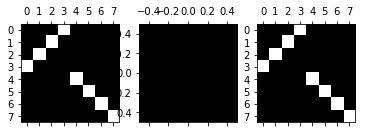

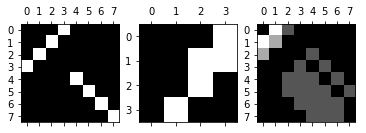

In [124]:
fmap1x1 = k1x1.reshape(k1x1.shape[0], k1x1.shape[1], 1, 1)
output0 = tfconv(ex0.reshape(1, ex0.shape[0], ex0.shape[1], 1), fmap1x1)
plot_figs([ex0, k1x1, output0[0, :, :, 0]])

fmap3x3 = k3x3.reshape(k3x3.shape[0], k3x3.shape[1], 1, 1)
output1 = tfconv(output0, fmap3x3)
plot_figs([output0[0, :, :, 0], k3x3, output1[0, :, :, 0]])

Por que kernels 1x1 são melhores? Porque se usarmos um número menor de kernels 1x1 (ex: 16) entre os 192 e os 32 kernels usados antes, o número global de operações será menor. Ou seja, em lugar de 192 kernels 3x3 e 5x5 processando entradas de 28x28 para 32 kernels de saída, teremos agora 192 kernels 3x3 e 5x5 processando entradas de 28x28 para 16 kernels 1x1. Estes, por sua vez, serão entrada de 32 kernels de saída. O número de operações é, então:

$(1^2 * 28^2 * 192 * 32 + 5^2 * 28^2 * 16 * 32) + (1^2 * 28^2 * 192 * 32 + 3^2 * 28^2 * 16 * 32) = 23.281.664$

Muito menos!!!

Redes de convolução Inception v2 basicamente vão incorporar essa ideia. Uma camada inception, em particular, é compostas por 4 operações paralelas: (1) convolução 1x1, (2) convolução 1x1 em série com 3x3, (3) convolução 1x1 em série com 5x5 e (4) uma maxpooling (pq? bom, pq todo mundo usa maxpooling) em série com convolução 1x1. Veja abaixo:

![](images/inception_implement.png)

Ao reduzir o número de operações & parâmetros, foi possível conseguir redes mais profundas. Com redes mais profundas, contudo, o problema de perda de gradientes se agravou, o que levou à ideia de fazer supervisão em várias camadas intermediárias da rede (em lugar de apenas no fim). Gradientes intermediários são então somados aos gradientes globais da rede durante a propagação retrógrada de forma a minimizar o problema de perda de gradientes.

Abaixo você pode ver 3 camadas softmax na rede GoogLeNet representadas por blocos laranja, além de nove camadas inception (fonte: http://joelouismarino.github.io/images/blog_images/blog_googlenet_keras/googlenet_diagram.png).  

![](images/googlenet_diagram.png)

A evolução das redes Inception seguiu com a introdução de BN (ainda na Inception v2) e uso de kernels de no máximo tamanho 3 (kernels 3x3). Para cobrir áreas tão amplas quanto a dos kernels 5x5 e 7x7 adotou-se o empilhamento de  kernels 3x3 e/ou séries de kernels 1x$n$ seguidos de $n$x1 ($n = 7$ em Inception v3). 

![](images/inceptionv3layer.png)

A arquitetura baseada nesta nova camada é a Inception v3 (ver https://arxiv.org/pdf/1512.00567.pdf para uma descrição de todas elas):

![](images/inceptionv3.png)

Arquiteturas Inception seguintes (v4) incluem camadas residuais, discutidas a seguir.

## Redes de Convolução Residuais

Observe as operações a seguir:

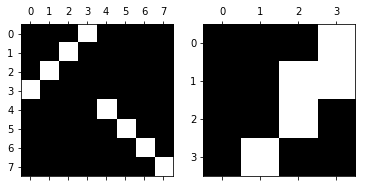

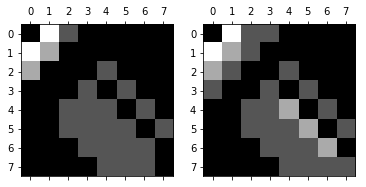

In [125]:
fmap3x3 = k3x3.reshape(k3x3.shape[0], k3x3.shape[1], 1, 1)
input0 = ex0.reshape(1, ex0.shape[0], ex0.shape[1], 1)
output0 = tfconv(input0, fmap3x3)
plot_figs([ex0, k3x3])
plot_figs([output0[0, :, :, 0], ex0 + output0[0, :, :, 0]])

Como antes, o kernel 3x3 foi aplicado à imagem ex0, produzindo uma interpretação onde o kernel parece observado na imagem. A quarta imagem corresponde à soma da entrada com a saída -- dizemos que a entrada foi 'copiada' para a saída. Ou seja, temos uma mistura entre onde o kernel foi observado e sua entrada original :/. Como interpretar isso? 

Note que uma pilha de camadas de uma rede neural aprende uma representação/mapeamento $\mathcal{F}({\bf x})$ para a sua entrada ${\bf x}$. Ao somarmos ${\bf x}$ à saída $\mathcal{F}$ da camada, o código aprendido passa a ser $\mathcal{H}({\bf x}) = \mathcal{F}({\bf x}) + {\bf x}$, ou seja, a rede aprende o resíduo da representaçao $\mathcal{F}({\bf x}) = \mathcal{H}({\bf x}) - {\bf x}$.  

![](images/resnet_block.png)

Mas por que isso seria útil? Em termos teóricos, se um mapeamento existente ${\bf x}$ já é ótimo, é mais simples uma pilha de camadas aprender um resíduo $\mathcal{F}({\bf x})$ próximo a zero que o mapeamento da função  identidade através de uma pilha de camadas não lineares. Generalizando esta ideia, podemos dizer que é mais simples otimizar resíduos.  

Em termos práticos, os neurônios que ainda não aprenderam nada útil e estão disparando próximo a zero, agora disparam uma cópia do valor da sua entrada (ou de uma entrada anterior, dependendo de onde é feita a 'cópia'). Assim, eles não bloqueiam mais o fluxo do sinal pela rede através das camadas, o que nos permite usar mais camadas!!! O resultado é a criação de redes com centenas de camadas, sem a necessidade de treinamento intermediário. 

## Redes de Convolução Densas

Tanto redes inception quanto residuais sugerem que camadas podem tirar proveito de atributos menos abstratos (obtidos via kernels menores em Inception ou de camadas anteriores em ResNets). 

Várias arquiteturas exploraram esta ideia de que atributos aprendidos em camadas anteriores podem ser úteis à frente, como as redes Fractais (2016). A ideia, contudo, foi generalizada pelas redes de convolução densamente conectadas (https://arxiv.org/pdf/1608.06993.pdf). Nestas, qualquer camada tem acesso a todos os atributos aprendidos em todas as camadas anteriores que seguem uma camada de pooling (uma vez que camadas de pooling mudam o tamanho do atributo -- kernel, o que impediria a sua utilização).

![](images/dense_convolve.jpeg)

O estudo destas arquiteturas demonstra que camadas posteriores tem alta probabilidade de usar atributos de camadas anteriores próximas. Isso é mais relevante quanto mais perto do início da rede está a camada, como visto na figura a seguir do paper sobre _densely connected convolution nets_ (onde cores indicam a influência das camadas). 

![](images/weight_impact.png)